In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import os
import sys
import numpy as np
from collections import namedtuple
import torch
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import forward
from src.fair.ancil import get_gas_params, get_thermal_params
from src.preprocessing import load_emissions_dataset, load_response_dataset

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [3]:
# Load historical scenario
inputs_hist = load_emissions_dataset('../data/inputs_historical.nc')
output_hist = load_response_dataset('../data/outputs_historical.nc')

# Load ssps
inputs_ssp126 = load_emissions_dataset('../data/inputs_ssp126.nc')
inputs_ssp245 = load_emissions_dataset('../data/inputs_ssp245.nc')
inputs_ssp370 = load_emissions_dataset('../data/inputs_ssp370.nc')
inputs_ssp585 = load_emissions_dataset('../data/inputs_ssp585.nc')

output_ssp126 = load_response_dataset('../data/outputs_ssp126.nc')
outputs_ssp245 = load_response_dataset('../data/outputs_ssp245.nc')
output_ssp370 = load_response_dataset('../data/outputs_ssp370.nc')
output_ssp585 = load_response_dataset('../data/outputs_ssp585.nc')

inputs = [inputs_hist, inputs_ssp126, inputs_ssp245, inputs_ssp370, inputs_ssp585]
outputs = [output_hist, output_ssp126, outputs_ssp245, output_ssp370, output_ssp585]

# Define named tuples for species emissions
species = ['CO2', 'CH4', 'SO2', 'BC']
Emissions = namedtuple(typename='Emissions', 
                       field_names=species, 
                       defaults=(None,) * len(species))
CummulativeEmissions = namedtuple(typename='CummulativeEmissions', 
                                  field_names=species, 
                                  defaults=(None,) * len(species))

# Extrat emissions and temperature anomaly arrays
def extract_arrays(xr_input, xr_output):
    # Extract time steps array
    time = xr_input.time.values
    
    # Extract cumulative emissions
    cum_CO2_emissions = xr_input.CO2.values
    cum_emissions = CummulativeEmissions(CO2=cum_CO2_emissions)
    
    # Compute emissions
    CO2_emissions = np.append(np.diff(cum_CO2_emissions)[0], np.diff(cum_CO2_emissions))
    CH4_emissions = xr_input.CH4.values
    weights = np.cos(np.deg2rad(xr_input.latitude))
    SO2_emissions = xr_input.SO2.weighted(weights).mean(['latitude', 'longitude']).data
    BC_emissions = xr_input.BC.weighted(weights).mean(['latitude', 'longitude']).data
    emissions = Emissions(CO2=CO2_emissions, CH4=CH4_emissions, 
                          SO2=SO2_emissions, BC=BC_emissions)
    
    # Compute average temperature anomaly
    weights = np.cos(np.deg2rad(xr_output.lat))
    tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data
    return time, cum_emissions, emissions, tas

In [4]:
# Fill them up with dataset
times = []
cum_emissions = CummulativeEmissions(CO2=[], CH4=[], SO2=[], BC=[])
emissions = Emissions(CO2=[], CH4=[], SO2=[], BC=[])
temperatures = []
for xr_input, xr_output in zip(inputs, outputs):
    time, cum_emission, emission, tas = extract_arrays(xr_input, xr_output)
    times.append(time)
    cum_emissions.CO2.append(cum_emission.CO2)
    emissions.CO2.append(emission.CO2)
    emissions.CH4.append(emission.CH4)
    emissions.SO2.append(emission.SO2)
    emissions.BC.append(emission.BC)
    temperatures.append(tas)

In [5]:
# Get FaIR parameters
gas_params_df = get_gas_params()
gas_kwargs = {k: np.asarray(list(v.values())) 
              for k, v in gas_params_df.T.to_dict().items()}
thermal_params_df = get_thermal_params()
d = thermal_params_df.T.d.values
q = thermal_params_df.T.q.values
# q[0] = -100.
base_kwargs = {'d': d,
               'q': q,
               **gas_kwargs}

In [6]:
# Run for historical emissions
Fs = []
tas_fair = []

time_hist = times[0]
emissions_hist = np.stack([emissions.CO2[0], 
                           emissions.CH4[0],
                           emissions.SO2[0],
                           emissions.BC[0]])
timestep = np.append(np.diff(time_hist), np.diff(time_hist)[-1])
ext_forcing = np.zeros_like(time_hist)
run_kwargs = {'inp_ar': emissions_hist.reshape(len(species), -1), 
              'timestep': timestep,
              'ext_forcing': ext_forcing,
              **base_kwargs}
res = forward.run(**run_kwargs)
Fs.append(res['RF'])
tas_fair.append(res['T'].flatten())

In [7]:
# Run for ssps - include historical emissions at beginning
for i in range(1, len(emissions.CO2)):
    time = np.concatenate([time_hist, times[i]])
    emissions_ssp = np.stack([emissions.CO2[i], 
                              emissions.CH4[i],
                              emissions.SO2[i],
                              emissions.BC[i]])
    emissions_ssp = np.hstack([emissions_hist, emissions_ssp])
    timestep = np.append(np.diff(time), np.diff(time)[-1])
    ext_forcing = np.zeros_like(time)
    run_kwargs = {'inp_ar': emissions_ssp.reshape(len(species), -1), 
                  'timestep': timestep,
                  'ext_forcing': ext_forcing,
                  **base_kwargs}
    res = forward.run(**run_kwargs)
    Fs.append(res['RF'][:, -len(times[i]):])
    tas_fair.append(res['T'].flatten()[-len(times[i]):])

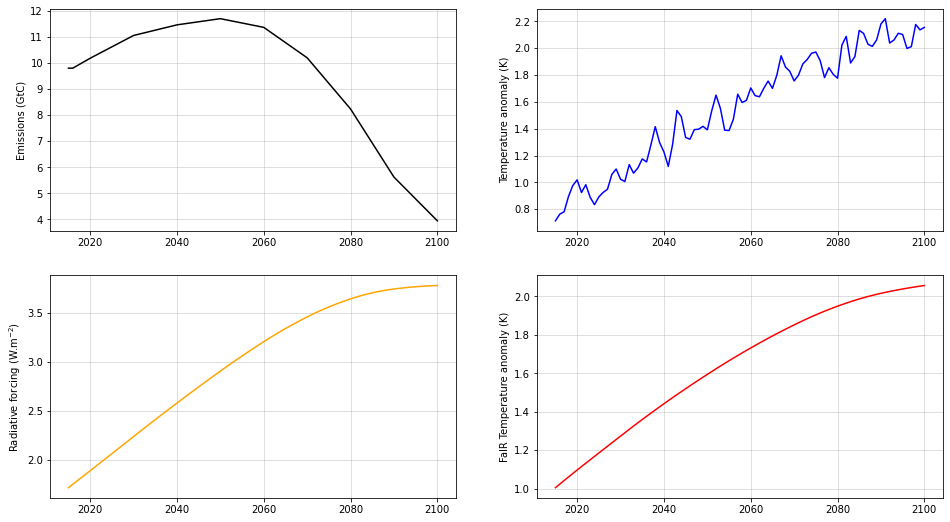

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

# hist = 0, ssp126 = 1, ssp285 = 2, ssp370 = 3, ssp585 = 4
idx = 2

ax[0, 0].plot(times[idx], emissions.CO2[idx].flatten(), color='black')
ax[0, 0].set_ylabel('Emissions (GtC)')
ax[0, 0].grid(alpha=0.5)

ax[0, 1].plot(times[idx], temperatures[idx], color='blue')
ax[0, 1].set_ylabel('Temperature anomaly (K)')
ax[0, 1].grid(alpha=0.5)

ax[1, 0].plot(times[idx], Fs[idx][0], color='orange')
ax[1, 0].set_ylabel('Radiative forcing (W.m$^{-2}$)')
ax[1, 0].grid(alpha=0.5)

ax[1, 1].plot(times[idx], tas_fair[idx], color='red')
ax[1, 1].set_ylabel('FaIR Temperature anomaly (K)')
ax[1, 1].grid(alpha=0.5)
plt.show()

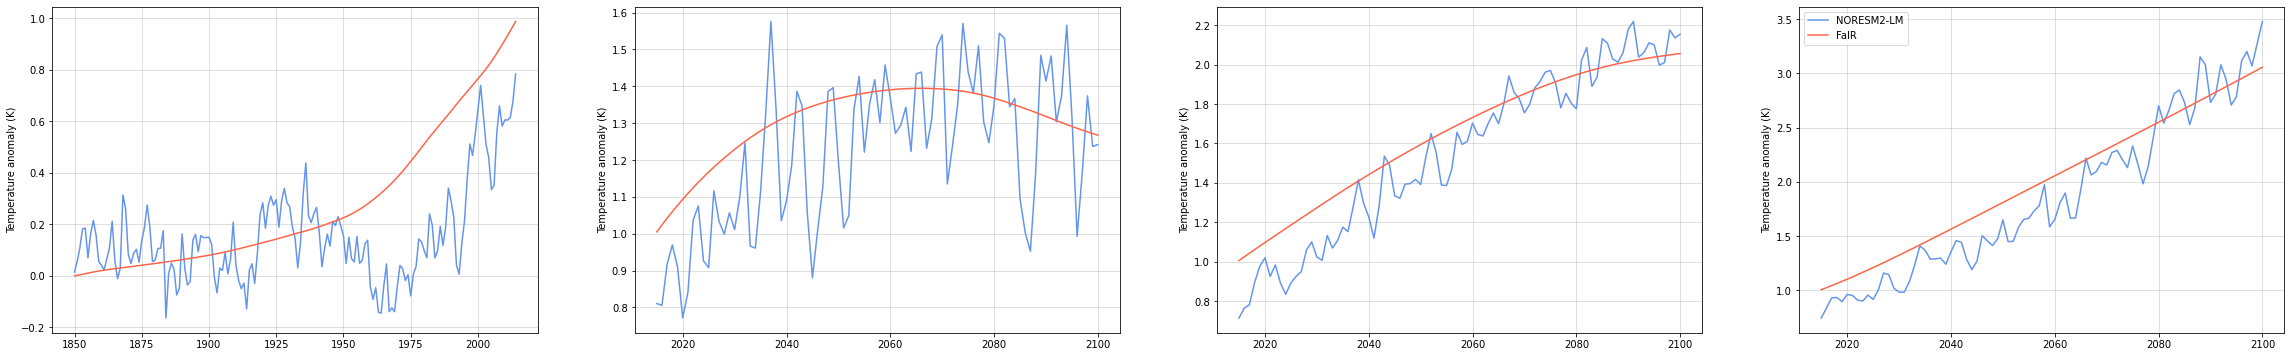

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(40, 6))

for i in range(len(emissions)):
    ax[i].plot(times[i], temperatures[i], color='cornflowerblue', label='NORESM2-LM')
    ax[i].set_ylabel('Temperature anomaly (K)')
    ax[i].plot(times[i], tas_fair[i].flatten(), color='tomato', label='FaIR')
    ax[i].grid(alpha=0.5)
plt.legend()
plt.show()

In [10]:
def get_ξ_from_forcing(q, d, F, dt=1):
    # Taken straight from FaIR codebase, not sure why computed this way
    ξ = q * (1 - np.exp(-dt / d)) * F
    return ξ

In [11]:
# Prepare tensors
train_idx = [0, 1, 3, 4]
test_idx = [2]

times_train = torch.from_numpy(np.stack([np.concatenate([times[i] for i in train_idx])])).float().squeeze()
Xtrain = np.stack([np.concatenate([cum_emissions.CO2[i] for i in train_idx]), 
                   np.concatenate([emissions.CH4[i] for i in train_idx]),
                   np.concatenate([emissions.SO2[i] for i in train_idx]),
                   np.concatenate([emissions.BC[i] for i in train_idx])])
Xtrain = torch.from_numpy(Xtrain).float().T
ytrain = torch.from_numpy(np.concatenate([temperatures[i] for i in train_idx])).float()
ΣF_train = np.concatenate([Fs[i] for i in train_idx], axis=-1).T.sum(axis=-1, keepdims=True)
ξ_train = torch.from_numpy(get_ξ_from_forcing(q, d, ΣF_train)).float()

times_test = torch.from_numpy(np.stack([np.concatenate([times[i] for i in test_idx])])).float().squeeze()
Xtest = np.stack([np.concatenate([cum_emissions.CO2[i] for i in test_idx]), 
                  np.concatenate([emissions.CH4[i] for i in test_idx]),
                  np.concatenate([emissions.SO2[i] for i in test_idx]),
                  np.concatenate([emissions.BC[i] for i in test_idx])])
Xtest = torch.from_numpy(Xtest).float().T
ytest = torch.from_numpy(np.concatenate([temperatures[i] for i in test_idx])).float()
ΣF_test = np.concatenate([Fs[i] for i in test_idx], axis=-1).T.sum(axis=-1, keepdims=True)
ξ_test = torch.from_numpy(get_ξ_from_forcing(q, d, ΣF_test)).float()

In [12]:
# Standardize inputs
mux, sigmax = Xtrain.mean(dim=0), Xtrain.std(dim=0)
Xtrain_std = (Xtrain - mux) / sigmax
Xtest_std = (Xtest - mux) / sigmax

In [62]:
class ThermalBoxesGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, means, kernels, t0, t, d, ξ, likelihood):
        X = torch.cat([X.view(-1, X.size(-1)), ξ, t.view(-1, 1)], dim=-1)
        super(ThermalBoxesGP, self).__init__(X, y, likelihood)
        self.means = torch.nn.ModuleList(means)
        self.kernels = torch.nn.ModuleList(kernels)
        self.t0 = t0
        self.d = torch.from_numpy(d).float()
        self.ξ = ξ
        self.nboxes = len(d)

    def forward_box(self, x, idx):
        t = x[..., -1]
        ξ = x[..., -self.nboxes-1:-1]
        x = x[..., :-self.nboxes-1]
        mean_box = torch.exp(-t / self.d[idx]) * self.means[idx](x) + ξ[:, idx]
        t_add_t = t[None, :] + t[:, None] - 2 * self.t0
        covar_box = torch.exp(-t_add_t / self.d[idx]) * self.kernels[idx](x)
        return mean_box, covar_box

    def forward(self, x):
        mean_x = []
        covar_x = []
        for idx in range(self.nboxes):
            mean_box, covar_box = self.forward_box(x, idx)
            mean_x.append(mean_box)
            covar_x.append(covar_box)
        mean_x = torch.stack(mean_x).sum(dim=0)
        covar_x = lazy.SumLazyTensor(*covar_x)
        return distributions.MultivariateNormal(mean_x, covar_x)

In [63]:
# Define thermal boxes GPs
m1 = means.ZeroMean()
m2 = means.ZeroMean()
m3 = means.ZeroMean()
k1 = kernels.RBFKernel(ard_num_dims=4, active_dims=[0, 1, 2, 3])
k2 = kernels.RBFKernel(ard_num_dims=4, active_dims=[0, 1, 2, 3])
k3 = kernels.RBFKernel(ard_num_dims=4, active_dims=[0, 1, 2, 3])
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(X=Xtrain_std, 
                       y=ytrain,
                       means=[m1, m2, m3], 
                       kernels=[k1, k2, k3], 
                       t0=torch.tensor(times[0][0]).float(),
                       t=times_train,
                       d=d,
                       ξ=ξ_train,
                       likelihood=likelihood)

In [64]:
# Find optimal model hyperparameters
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
n_iter = 200
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    output = model.forward(model.train_inputs[0])
    loss = -mll(output, ytrain)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

Iter:   0%|          | 0/200 [00:00<?, ?it/s]

In [71]:
with torch.no_grad():
    m0, k0 = model.forward_box(model.train_inputs[0], 0)
    m1, k1 = model.forward_box(model.train_inputs[0], 1)
    m2, k2 = model.forward_box(model.train_inputs[0], 2)
print(model.d)

tensor([2.3095e+02, 1.8415e+00, 2.6163e-02])


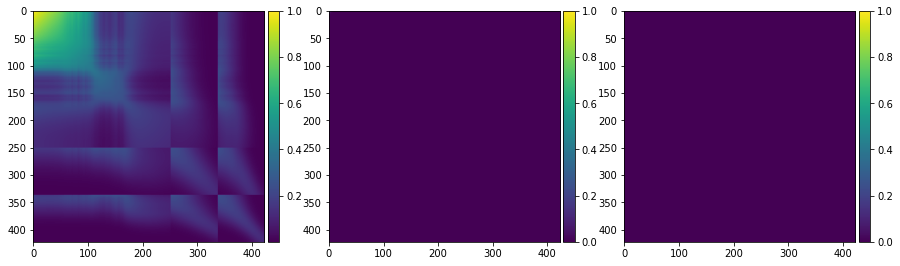

In [73]:
fig, ax = plt.subplots(1, 3, figsize=((15, 5)))
im = ax[0].imshow(k0.evaluate())
colorbar(im)
im = ax[1].imshow(k1.evaluate())
colorbar(im)
im = ax[2].imshow(k2.evaluate())
colorbar(im)

In [65]:
model.eval()
with torch.no_grad():
    test_inputs = torch.cat([Xtest_std.view(-1, Xtest_std.size(-1)), 
                             ξ_test, 
                             times_test.view(-1, 1)], dim=-1)
    pred = model(test_inputs, times_test)
    noisy_pred = model.likelihood(pred)

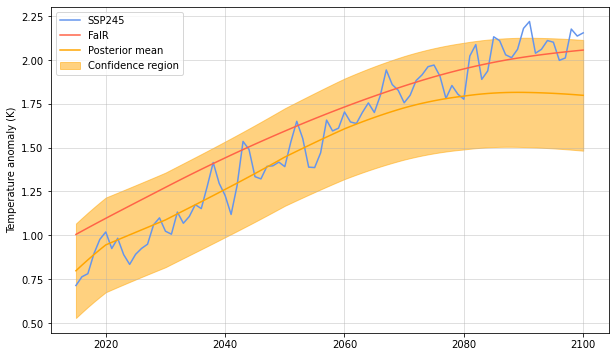

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

time_test = times[test_idx[0]]
tas_test = temperatures[test_idx[0]]
tas_fair_test = tas_fair[test_idx[0]]
lb, ub = noisy_pred.confidence_region()

ax.plot(time_test, tas_test, color='cornflowerblue', label='SSP245')
ax.set_ylabel('Temperature anomaly (K)')
ax.plot(time_test, tas_fair_test, color='tomato', label='FaIR')
ax.plot(time_test, pred.mean, color='orange', label='Posterior mean')
ax.fill_between(time_test, lb, ub, alpha=0.5, color='orange', label='Confidence region')
ax.grid(alpha=0.5)
plt.legend()
plt.show()

In [67]:
rmse = torch.sqrt(torch.square(pred.mean - tas_test).mean()).item()
ll = noisy_pred.log_prob(torch.from_numpy(tas_test).float()).item()

print("RMSE = ", rmse)
print("LL = ", ll)

RMSE =  0.15935512601562538
LL =  68.90348815917969


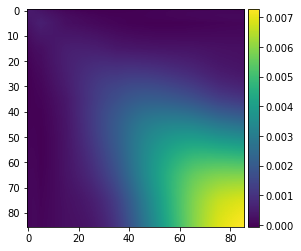

In [68]:
im = plt.imshow(pred.covariance_matrix)
colorbar(im)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/torch/distributions/distribution.py:151: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jit

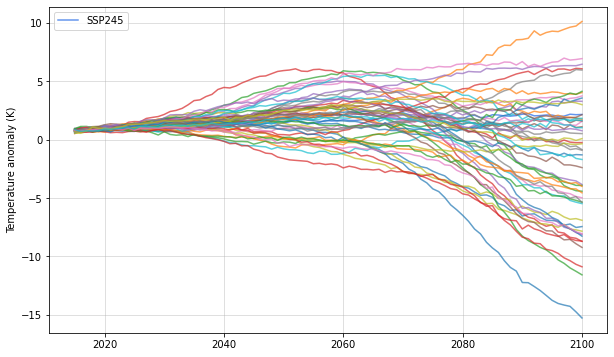

In [61]:
torch.random.manual_seed(5)
draws = pred.sample_n(50)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(time_test, tas_test, color='cornflowerblue', label='SSP245')
ax.set_ylabel('Temperature anomaly (K)')
for draw in draws:
    ax.plot(time_test, draw, alpha=0.7)
ax.grid(alpha=0.5)
plt.legend()
plt.show()